In [1]:
import os
import sys


up1 = os.path.abspath('../../utils/') 
up2 = os.path.abspath('../../models/') 
sys.path.insert(0, up1)
sys.path.insert(0, up2)

In [2]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow, plot_confusion_matrix
from motion_network import getKerasCifarMotionModel2, getKerasCifarMotionModelOnly
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from keras.optimizers import SGD
import cv2 
import numpy as np
import keras

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.initializers import Ones
from keras import optimizers

def getModel(lr=1e-2):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('sigmoid'))

    optimizers.SGD(lr=lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [4]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow

training_options = { 'rescale' : 1./255, 
                     'samplewise_center': True, 
                         'samplewise_std_normalization':True,
                            'zoom_range' : 0.2, 
                            'horizontal_flip' : True}

validation_options = { 'rescale' : 1./255,
                     'samplewise_center': True, 
                         'samplewise_std_normalization':True}




params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 128,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 10,
           'validation' : False,
                'enable_augmentation' : True,
               'training_opts' : training_options}

params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size':128,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 10,
           'validation' : True,
               'validation_opts' : validation_options}

id_labels_train = get_train_data_opt_flow('../../data/ucf101_splits/trainlist01_small.txt')
labels = id_labels_train[1]
id_test = get_test_data_opt_flow('../../data/ucf101_splits/testlist01_small.txt', \
                       '../../data/ucf101_splits/classInd_small.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)


validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [5]:
model  = getModel(1e-3)

In [14]:
model.load_weights('../../data/weights/model_10_class_255_epochs.hdf5')

In [23]:
predict = np.empty((len(validation_generator)*128*4, 10), dtype=float)
labels = np.empty((len(validation_generator)*128*4, 10), dtype=int)
predict.shape

(1536, 10)

In [24]:

for i, (X, y) in enumerate(validation_generator):
    predict[i*128:(i+1)*128,] = model.predict(X)
    labels[i*128:(i+1)*128] = y
    if i == len(validation_generator)*4 - 1:
        break
    

In [25]:
rounded_predictions = predict.argmax(axis=1)

In [26]:
rounded_labels = labels.argmax(axis=1)

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
cm = confusion_matrix(rounded_labels, rounded_predictions)

In [29]:
cm_plot_labels = [str(i) for i in range(1,11)]

Confusion matrix, without normalization
[[109  31  13   5   1   3   4   9   0   1]
 [ 28  73  16   1   2   0   2   1   1   0]
 [ 19   9  58  27  10   8  23   2   3   5]
 [ 16   7   5  88   3   2   8   7   1   3]
 [  7   5  10  23  65   1   6   6   0   1]
 [  4   5  14  20   1 106   3   4  13   2]
 [  5  10  26  17   5   3  79  16   3   4]
 [  7   4  18  13   1   8  29  50   3   3]
 [  0   0   1   2   1  15   0   5 124   0]
 [  4   1  17   6   2   2   6   9   0 137]]


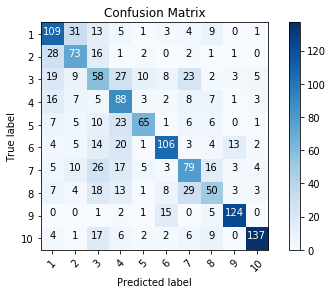

In [32]:
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=False)